## Adult Data

** Import the libraries you usually use for data analysis.**

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,classification_report
from mpl_toolkits.mplot3d import Axes3D # 3d scatter plot
import time
%matplotlib inline

In [119]:
# parameters
n_centroids = 2
n_init = 40

In [120]:
# load training set
train = pd.read_csv('./clean_data/adult_train.txt',index_col=False)
train_labels = train['income'].values
train = train.drop('income',axis=1).values

# load testing set
test = pd.read_csv('./clean_data/adult_test.txt',index_col=False)
test_labels = test['income'].values
test = test.drop('income',axis=1).values

In [121]:
# normalize everything such that categoricals are not affected
a = train
#train = (a - a.min()) / (a.max() - a.min())
train = (a - a.mean()) / np.std(a)

b = test
#test = (b - b.min()) / (b.max() - b.min())
test = (b - b.mean()) / np.std(b)


### Apply K Means

In [122]:
kmeans = KMeans(n_clusters=n_centroids, n_init=n_init, n_jobs=4)
kmeans.fit(train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=40, n_jobs=4, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [123]:
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))

[[13952  8702]
 [ 2343  5165]]
             precision    recall  f1-score   support

          0       0.86      0.62      0.72     22654
          1       0.37      0.69      0.48      7508

avg / total       0.74      0.63      0.66     30162



### Predicting on test set

In [124]:
b = kmeans.predict(test)

In [125]:
print(confusion_matrix(test_labels, b))
print(classification_report(test_labels, b))

[[6931 4429]
 [1169 2531]]
             precision    recall  f1-score   support

          0       0.86      0.61      0.71     11360
          1       0.36      0.68      0.47      3700

avg / total       0.73      0.63      0.65     15060



## Choosing number of clusters via Silhoutte + Model Complexity

In [186]:
from sklearn.metrics import silhouette_samples, silhouette_score
n_seed = 111
nclusters = 50
nfeatures = 65
data_frac = 5000

In [187]:
X = train #.values # converting df to np.array
X = X[0:data_frac]
y = train_labels

In [188]:
sil = []
time_clust = []
for iclusters in range(2,nclusters):
    start = time.time()
    clusterer = KMeans(n_clusters=iclusters,random_state=n_seed)
    cluster_labels = clusterer.fit_predict(X)
    end = time.time()
    sil.append(silhouette_score(X, cluster_labels))
    time_clust.append(end - start) 
    

In [178]:
time_iter = []
time_sample = []
niter = nclusters # just for plotting them togather
for iiter in range(2,niter):
    # iterations
    start = time.time()
    clusterer = KMeans(n_clusters= 4, random_state=n_seed, n_init = iiter, max_iter = 100)
    cluster_labels = clusterer.fit_predict(X)
    end = time.time()
    time_iter.append(end - start)    
    #samples
    start = time.time()
    isample = int(data_frac * iiter/100)
    cluster_labels = clusterer.fit_predict(X[0:isample])
    end = time.time()
    time_sample.append(end - start)      
       

In [189]:
y = np.asarray(sil)
x = range(2,nclusters)
sil_max = x[y.argmax()]

(48, 48)

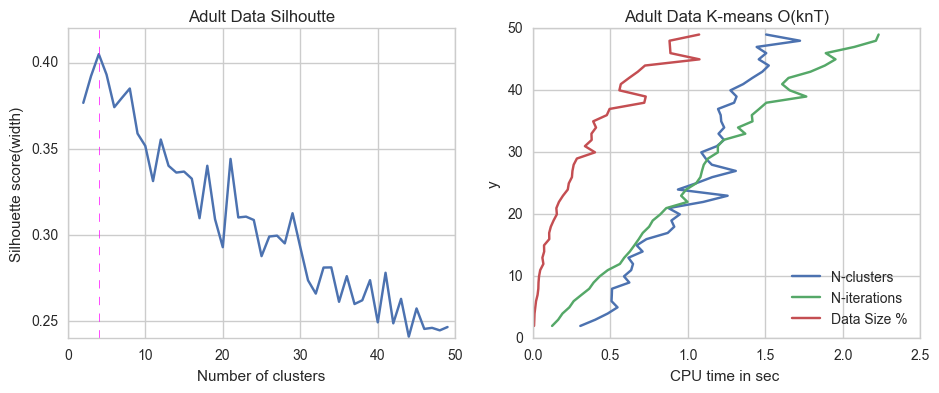

In [206]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(11,4))
p1 = plt.subplot(121, title = 'Adult Data Silhoutte')
plt.plot(x, y)
plt.ylabel('Silhouette score(width)')
plt.xlabel('Number of clusters')
plt.axvline(x=sil_max,color='magenta', linestyle='--', linewidth=0.5)

p2 = plt.subplot(122, title = 'Adult Data K-means O(knT)')
plt.plot(time_clust,x)
plt.plot(time_iter,x)
plt.plot(time_sample,x)
plt.legend(["N-clusters","N-iterations","Data Size %"],loc=4)
plt.xlabel('CPU time in sec ')
plt.ylabel('y')

### The average complexity is given by O(k n T), were n is the number of samples and T is the number of iteration.

### Apply EM

In [12]:
from sklearn.mixture import GaussianMixture
n_init = 2
n_seed = 111

In [13]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=n_init, max_iter=100)
gm.fit(train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=2, precisions_init=None,
        random_state=111, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [14]:
gm_labels = gm.predict(train)

In [15]:
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[17944  4710]
 [ 4152  3356]]
             precision    recall  f1-score   support

          0       0.81      0.79      0.80     22654
          1       0.42      0.45      0.43      7508

avg / total       0.71      0.71      0.71     30162



In [16]:
test_gm = gm.predict(test)
print(confusion_matrix(test_labels, test_gm))
print(classification_report(test_labels, test_gm))

[[8913 2447]
 [2031 1669]]
             precision    recall  f1-score   support

          0       0.81      0.78      0.80     11360
          1       0.41      0.45      0.43      3700

avg / total       0.71      0.70      0.71     15060



# Note!
**Since training was not provided any information about target feature, it makes sence to see very close accuracy
on both training and testing sets.**

### Apply PCA to Normalized Data 

In [17]:
from sklearn.decomposition import PCA, FastICA

In [18]:
train = pd.DataFrame(train)
n_features = len(train.columns)

## Try it on whole data

In [19]:
# when n_comp is given as fraction and svd solver is full, then algorithm chooses # pc components
# such that model explains "n_components= of varience
pca_all = PCA(n_components=0.99,  svd_solver = 'full')
pca_all.fit(train)
pca_n = pca_all.transform(train)

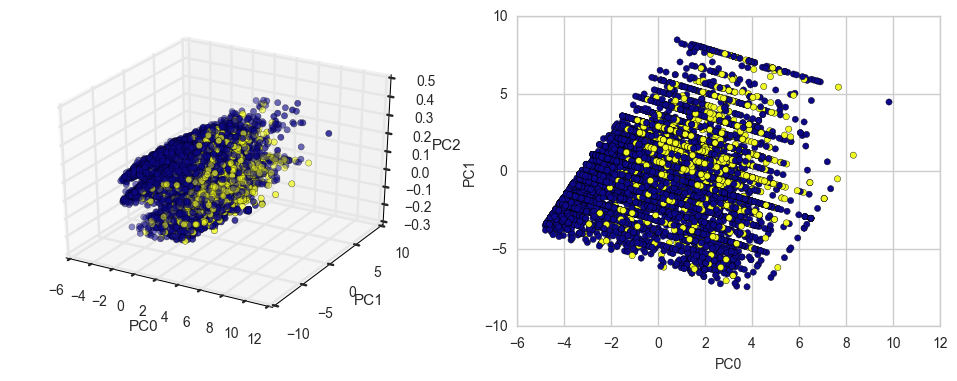

In [20]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pca_n[:,0], pca_n[:,1],pca_n[:,2],c=train_labels,cmap='plasma')
ax1.set_xlabel('PC0')
ax1.set_ylabel('PC1')
ax1.set_zlabel('PC2')

ax2 = fig.add_subplot(122)
ax2.scatter(pca_n[:,0], pca_n[:,1],c=train_labels,cmap='plasma')
plt.xlabel('PC0', fontsize = 10)
plt.ylabel('PC1', fontsize = 10)


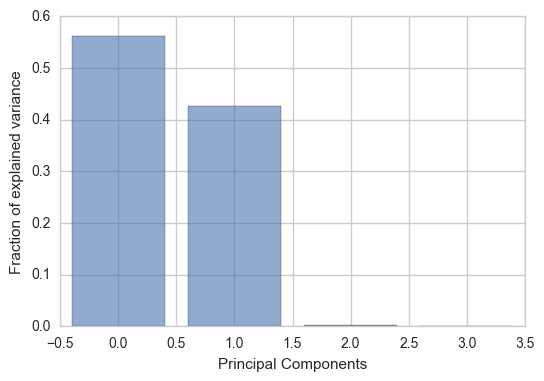

In [21]:
aig_vals = pca_all.explained_variance_ratio_[0:10]
y_pos = np.arange(len(aig_vals))
 
plt.bar(y_pos, aig_vals, align='center', alpha=0.6)
plt.ylabel('Fraction of explained variance')
plt.xlabel('Principal Components') 

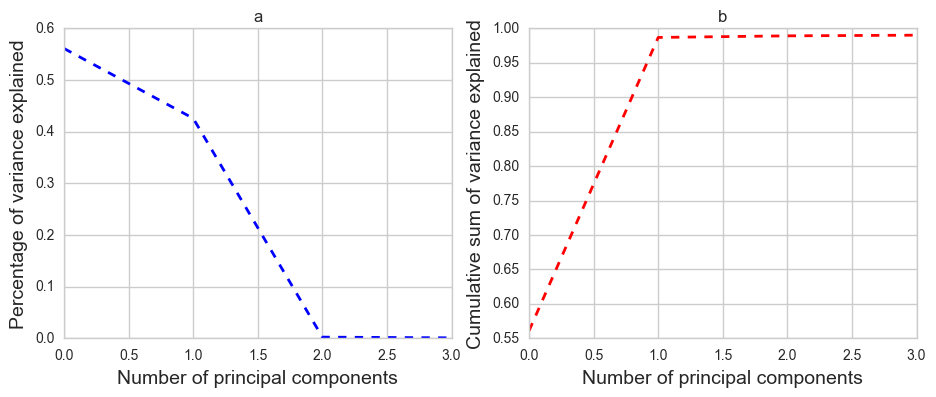

In [22]:
y = pca_all.explained_variance_ratio_
x = np.arange(len(y))

# plot pca
fig = plt.figure(figsize=(11,4))
sub1 = plt.subplot(121, title = 'a')
plt.xlabel('Number of principal components', fontsize = 14)
plt.ylabel('Percentage of variance explained', fontsize = 14)
plt.plot(x ,y, '--',lw=2., color='blue')

sub2 = plt.subplot(122, title = 'b')
plt.xlabel('Number of principal components', fontsize = 14)
plt.ylabel('Cumulative sum of variance explained', fontsize = 14)
plt.plot(x ,np.cumsum(y), '--',lw=2.0, color='red')

### Apply ICA

In [68]:
ica =FastICA(tol=0.001, whiten=True, fun='logcosh', max_iter=200, random_state=n_seed)
ica_all = ica.fit_transform(train)

/home/talant/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


### Applying k-means to ICA output

In [69]:
kmeans = KMeans(n_clusters=n_centroids, random_state = n_seed)
kmeans.fit(ica_all)
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))

[[ 9306 13348]
 [ 6541   967]]
             precision    recall  f1-score   support

          0       0.59      0.41      0.48     22654
          1       0.07      0.13      0.09      7508

avg / total       0.46      0.34      0.39     30162



### Applying EM to ICA output

In [70]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=n_init, max_iter=100)
gm.fit(ica_all)
gm_labels = gm.predict(ica_all)
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[ 1419 21235]
 [   84  7424]]
             precision    recall  f1-score   support

          0       0.94      0.06      0.12     22654
          1       0.26      0.99      0.41      7508

avg / total       0.77      0.29      0.19     30162



In [71]:
from scipy.stats import kurtosis
y = kurtosis(ica_all, fisher=True)
x = np.arange(len(y)) 

In [72]:
kurt_max = x[y.argmax()]
kurtosis_thresh = y.max()/3

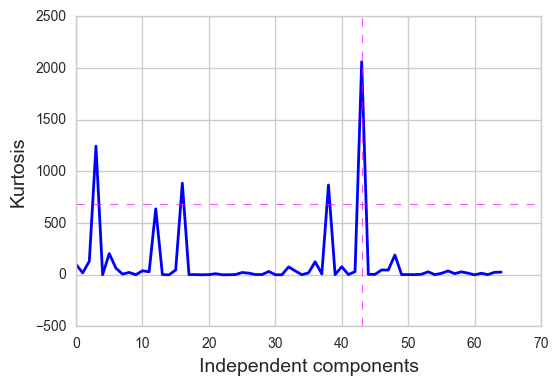

In [73]:
# plot ica
fig = plt.figure(figsize=(6,4))
plt.xlabel('Independent components', fontsize = 14)
plt.ylabel('Kurtosis', fontsize = 14)
plt.plot(x ,y, '-',lw=2., color='blue')
plt.axvline(x=kurt_max,color='magenta', linestyle='--', linewidth=0.5)
plt.axhline(y=kurtosis_thresh,color='magenta', linestyle='--', linewidth=0.5)

### Visualize ICA components with highest Kurtosis

In [74]:
tmp = [y > kurtosis_thresh]
indx = np.where(tmp)[1]

In [75]:
ica_all = pd.DataFrame(ica_all)
ica_keep = ica_all[indx]

In [76]:
indx

array([ 3, 16, 38, 43])

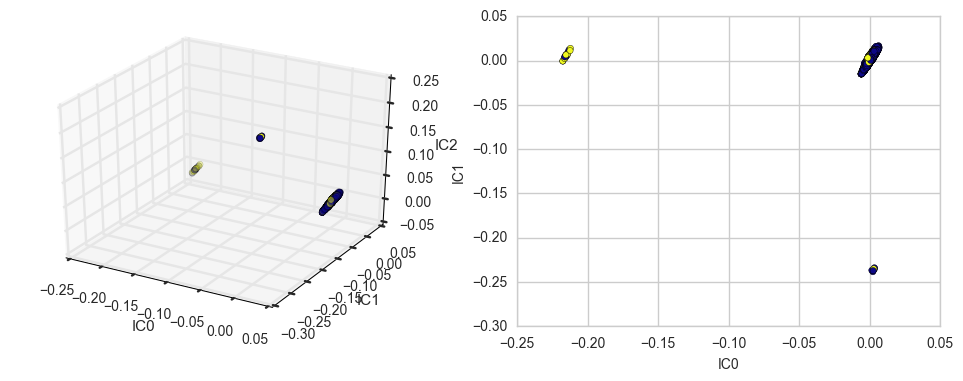

In [77]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(ica_keep[indx[0]], ica_keep[indx[1]],ica_keep[indx[2]],c=train_labels,cmap='plasma')
ax1.set_xlabel('IC0')
ax1.set_ylabel('IC1')
ax1.set_zlabel('IC2')

ax2 = fig.add_subplot(122)
ax2.scatter(ica_keep[indx[0]], ica_keep[indx[1]],c=train_labels,cmap='plasma')
plt.xlabel('IC0', fontsize = 10)
plt.ylabel('IC1', fontsize = 10)

### Apply k-means to reduced dim by ICA

In [78]:
kmeans = KMeans(n_clusters=n_centroids, random_state = n_seed)
kmeans.fit(ica_keep)
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))


[[22646     8]
 [ 7507     1]]
             precision    recall  f1-score   support

          0       0.75      1.00      0.86     22654
          1       0.11      0.00      0.00      7508

avg / total       0.59      0.75      0.64     30162



### Apply EM to reduced dim by ICA

In [79]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=n_init, max_iter=100)
gm.fit(ica_keep)
gm_labels = gm.predict(ica_keep)
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[   19 22635]
 [   11  7497]]
             precision    recall  f1-score   support

          0       0.63      0.00      0.00     22654
          1       0.25      1.00      0.40      7508

avg / total       0.54      0.25      0.10     30162



### Apply k-means to PCA output

In [80]:
kmeans = KMeans(n_clusters=n_centroids, random_state = n_seed)
kmeans.fit(pca_n)
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))

[[13955  8699]
 [ 2321  5187]]
             precision    recall  f1-score   support

          0       0.86      0.62      0.72     22654
          1       0.37      0.69      0.48      7508

avg / total       0.74      0.63      0.66     30162



### Apply EM to PCA output

In [81]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=n_init, max_iter=100)
gm.fit(pca_n)
gm_labels = gm.predict(pca_n)
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[15876  6778]
 [ 1833  5675]]
             precision    recall  f1-score   support

          0       0.90      0.70      0.79     22654
          1       0.46      0.76      0.57      7508

avg / total       0.79      0.71      0.73     30162

